In [144]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

np.random.seed(88)

# Phase 1 - HW #1

In [145]:
drilling_costs = pd.read_excel("Analysis_Data.xlsx", sheet_name="Drilling Cost", skiprows=2)
price_projections = pd.read_excel("Analysis_Data.xlsx", sheet_name="Price Projections", skiprows=2)

# subset 1991-2007
drilling_costs = drilling_costs[(drilling_costs['Date'] >= pd.to_datetime("1991-01-01")) & 
                                (drilling_costs['Date'] < pd.to_datetime("2007-06-30"))]

# changing column names
drilling_costs.rename(columns = {'U.S. Nominal Cost per Crude Oil Well Drilled (Thousand Dollars per Well)': 'Crude_Oil_Cost',
                                 'U.S. Nominal Cost per Natural Gas Well Drilled (Thousand Dollars per Well)': 'Natural_Gas_Cost',
                                 'U.S. Nominal Cost per Dry Well Drilled (Thousand Dollars per Well)': "Dry_Well_Cost",
                                 'Arithmetic Return - Crude Oil': 'Crude_Oil_Return',
                                 'Arithmetic Return - Natural Gas': 'Natural_Gas_Return',
                                 'Arithmetic Return - Dry Well': 'Dry_Well_Return'}, inplace=True)

# making numeric
drilling_costs['Crude_Oil_Return'] = pd.to_numeric(drilling_costs['Crude_Oil_Return'])
drilling_costs['Natural_Gas_Return'] = pd.to_numeric(drilling_costs['Natural_Gas_Return'])
drilling_costs['Dry_Well_Return'] = pd.to_numeric(drilling_costs['Dry_Well_Return'])

# Arithmetic changes list
arithmetic_changes = np.concatenate((drilling_costs['Crude_Oil_Return'], 
                                     drilling_costs['Natural_Gas_Return'], 
                                     drilling_costs['Dry_Well_Return']))

# Phase 2 - HW #2

In [146]:
data = []
# Correlation matrix
R = np.array([[1, 0.64], [0.64, 1]])
L = sp.linalg.cholesky(R, lower=False)

# giving you a standardized vector 
def standardize(x):
  x_std = (x - np.mean(x))/np.std(x)
  return(x_std)

# reverseing the standardization
def destandardize(x_std, x):
  x_old = (x_std * np.std(x)) + np.mean(x)
  return(x_old)

production = np.random.lognormal(mean = 6, sigma = 0.28, size = 500000)
decline = np.random.uniform(low = 0.15, high = 0.32, size = 500000)

both_PD = np.array([standardize(decline), standardize(production)])

PD = L @ both_PD

final_PD = np.array([destandardize(PD[0], decline), destandardize(PD[1], production)])

# Phase 3

## Simulate Probablity of Wet Well & Hydrocarbons

c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


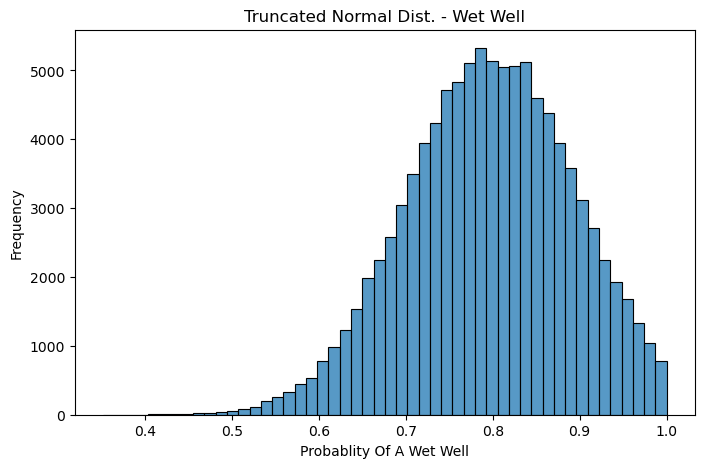

c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


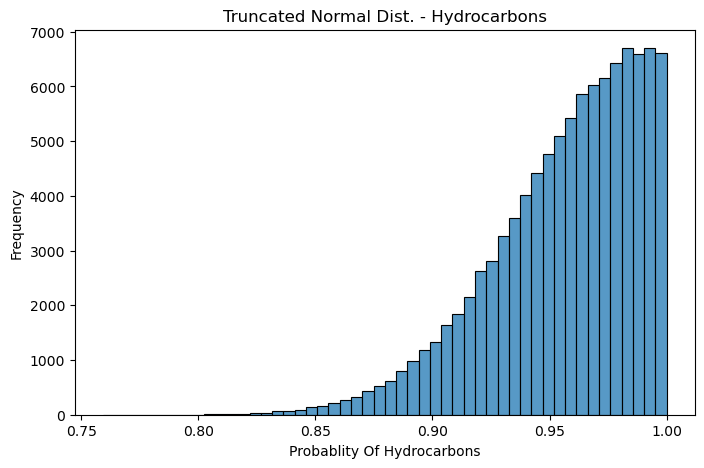

In [147]:
# P(wet) 
a, b = 0, 1  # Truncation limits (probabilities between 0 and 1)
mu, sigma = 0.80, 0.1  # Mean and standard deviation of the normal distribution
trunc_norm = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
p_wet = trunc_norm.rvs(size=100000)  # Sample a probability value 100000 times

# Plot P(wet)  out
plt.figure(figsize=(8, 5)) 
ax = sns.histplot(data=p_wet, bins=50)
ax.set_title("Truncated Normal Dist. - Wet Well")
ax.set_xlabel("Probablity Of A Wet Well")
ax.set_ylabel("Frequency")
plt.show()


# P(hydrocarbons) 
a, b = 0, 1  # Truncation limits (probabilities between 0 and 1)
mu, sigma = 0.99, 0.05  # Mean and standard deviation of the normal distribution
trunc_norm = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
p_hydro = trunc_norm.rvs(size=100000)  # Sample a probability value 100000 times

# Plot P(hydrocarbons) out
plt.figure(figsize=(8, 5)) 
ax = sns.histplot(data=p_hydro, bins=50)
ax.set_title("Truncated Normal Dist. - Hydrocarbons")
ax.set_xlabel("Probablity Of Hydrocarbons")
ax.set_ylabel("Frequency")
plt.show()

## Determine The Number of Drillable Wells

c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


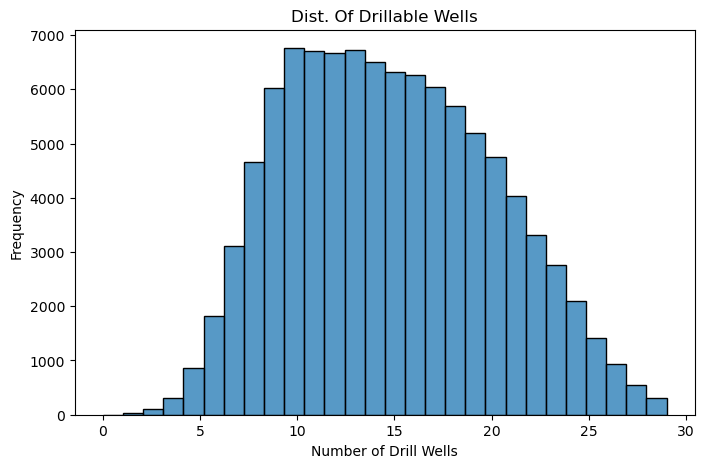

In [148]:
# Simulate number of total wells
num_wells = np.random.uniform(low = 10, high = 30, size=100000).astype(int) # cast as int bc cant have half a well (always rounding down)

# Simulate how many of the total wells are wet
producing_wells = np.random.binomial(n=num_wells, p=p_wet)

# Simulate how many of the wet wells have hydrocarbons present
hydrocarbon_wells = np.random.binomial(n=producing_wells, p=p_hydro)


# Plot it out
plt.figure(figsize=(8, 5)) 
ax = sns.histplot(hydrocarbon_wells, bins=28)
ax.set_title("Dist. Of Drillable Wells")
ax.set_xlabel("Number of Drill Wells")
ax.set_ylabel("Frequency")
plt.show()

In [ ]:
# VaR at 5% level
drill_Var = np.quantile(hydrocarbon_wells, 0.05)
print(f'The 5% VaR for drillable wells is {drill_Var}')

# Conditional VaR at 5% level
drill_CVaR = np.mean(hydrocarbon_wells[hydrocarbon_wells < drill_Var])
print(f'The 5% CVaR for drillable wells is {drill_CVaR}')

The 5% VaR for drillable wells is 7.0
The 5% CVaR for drillable wells is 5.3780254777070065
